In [1]:
# Import necessary libraries

import pandas as pd
import sqlite3
import os
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from random import sample
from collections import Counter
from itertools import islice

In [2]:
# import the three cleaned CSV's from previous milestones. Please note I did some additional cleaning to 
# Milestone 4 data to make it more robust.

flat_file = pd.read_csv('cleaned_tracks.csv', index_col=0)
music_df = flat_file[['track_name','popularity','duration_ms','explicit','artist_name','release_date','danceability','loudness','speechiness','acousticness','instrumentalness','liveness','tempo','time_signature']]
rnrhof = pd.read_csv('rnrhof2.csv', index_col=0)
lyrics = pd.read_csv('lyric_df2.csv', index_col=0)

In [3]:
with sqlite3.connect('rnrhofdb') as conn: #establishing a connection to a database named rock n roll hall of fame db
    cursor = conn.cursor() 
    cursor.execute("CREATE TABLE IF NOT EXISTS rnrhof ('inductionyear' INT, 'name' TEXT, 'inductedmembers' TEXT, 'inductedby' TEXT)") #create table for the rnrhof webscraped data
    cursor.execute("CREATE TABLE IF NOT EXISTS artist ('trackname' TEXT, 'popularity' INT, 'duration' INT, 'explicit' INT, 'artistname' TEXT, 'releasedate' TEXT, 'danceability' INT, 'loudness' INT, 'speechiness' INT, 'acousticness' INT, 'instrumentalness' INT, 'liveness' INT, 'tempo' INT, 'timesignature' INT)")#create table for the flat file data
    cursor.execute("CREATE TABLE IF NOT EXISTS lyrics ('artistname' TEXT, 'trackname' TEXT, 'lyrics' TEXT)") #create table for the API lyrics data
    conn.commit()
    rnrhof.to_sql('rnrhof', conn, if_exists='replace',index=False) #upload the appropriate dataframes to their corresponding tables in the db
    music_df.to_sql('artist', conn, if_exists='replace',index=False)
    lyrics.to_sql('lyrics', conn, if_exists='replace',index=False)

C:\Users\chels\anaconda3\lib\site-packages\pandas\core\generic.py:2653: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


In [5]:
# checking to make sure the tables were generated correctly & actually had data inserted in them
sql = """
SELECT * FROM rnrhof LIMIT 5
"""
rows = cursor.execute(sql)
for row in rows:
    print(row)

(1986, 'chuck berry', None, 'keith richards  ')
(1986, 'james brown', None, 'steve winwood  ')
(1986, 'ray charles', None, 'quincy jones  ')
(1986, 'sam cooke', None, 'herb alpert  ')
(1986, 'fats domino', None, 'billy joel  ')


In [6]:
# creating the join with all three tables (inner join) and spitting out a dataframe
sql = """SELECT a.*, l.lyrics
FROM artist a
JOIN rnrhof r 
JOIN lyrics l
ON a.artist_name = r.name
AND a.artist_name = l.artistname
"""
rows = cursor.execute(sql)
column_names = [col[0] for col in rows.description]
combined_df = pd.DataFrame(cursor.fetchall(), columns=column_names)

In [7]:
combined_df.columns #finding column names just to be sure

Index(['track_name', 'popularity', 'duration_ms', 'explicit', 'artist_name',
       'release_date', 'danceability', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'tempo',
       'time_signature', 'Lyrics'],
      dtype='object')

In [8]:
combined_df.drop_duplicates(subset=['Lyrics'], inplace=True)
combined_df.drop_duplicates(subset=['track_name'], inplace=True) #removing duplicates

In [9]:
# I was curious how many unique artist names were in the join
print(sorted(combined_df['artist_name'].unique())) 

['aretha franklin', 'bill withers', 'bo diddley', 'bobby darin', 'buddy guy', 'buddy holly', 'chuck berry', 'darlene love', 'del shannon', 'dion', 'donovan', 'eddie cochran', 'elvis presley', 'etta james', 'fats domino', 'gene pitney', 'jackie wilson', 'james brown', 'jerry lee lewis', 'joan baez', 'john lee hooker', 'johnny cash', 'lavern baker', 'little richard', 'lloyd price', 'miles davis', 'muddy waters', 'nina simone', 'ray charles', 'ricky nelson', 'ritchie valens', 'roy orbison', 'ruth brown', 'sam cooke', 'solomon burke', 'stevie wonder', 'the beach boys', 'the beatles', 'the byrds', 'the doobie brothers', 'the drifters', 'the flamingos', 'the hollies', 'the impressions', 'the isley brothers', 'the kinks', 'the moody blues', 'the platters', 'the ronettes', 'the shirelles', 'the supremes', 'the temptations', 'tom waits']


In [10]:
len(combined_df['artist_name'].unique())

53

In [11]:
combined_df.shape

(53, 15)

In [12]:
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='red', colormap='Pastel1', collocations=False, stopwords=STOPWORDS).generate(str(combined_df.Lyrics))

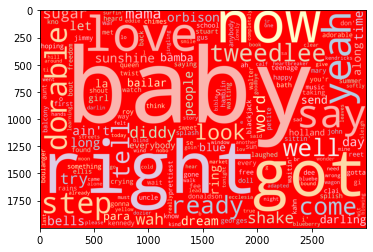

In [13]:
# WordCloud showing the most often used words in at least one song per each RnR HoF'er that I could get lyrics for
plt.imshow(wordcloud)
plt.show()

In [14]:
# creating another inner joined table, but without lyric data this time

sql = """SELECT a.*, r.*
FROM artist a
JOIN rnrhof r 
ON a.artist_name = r.name
"""
rows = cursor.execute(sql)
column_names = [col[0] for col in rows.description]
rnrhofdata_df = pd.DataFrame(cursor.fetchall(), columns=column_names)

In [15]:
rnrhofdata_df.shape

(24396, 18)

In [16]:
rnrhofdata_df.head()

,track_name,popularity,duration_ms,explicit,artist_name,release_date,danceability,loudness,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature,Induction Year,Name,Inducted Members,Inducted By
0,evil gal blues live,1,161893,0,aretha franklin,1927-01-01,0.496,-8.876,0.0519,0.629,0.076800,0.1620,119.018,4,1987,aretha franklin,None,keith richards
1,it aint necessarily so from porgy and bess,7,186160,0,aretha franklin,1936-01-01,0.648,-13.917,0.0837,0.896,0.000036,0.1100,86.735,4,1987,aretha franklin,None,keith richards
2,blue xmas to whom it may concern,7,159773,0,miles davis,1936-01-01,0.432,-16.758,0.0667,0.365,0.000004,0.1720,94.998,4,2006,miles davis,None,herbie hancock
3,aint no sunshine,12,124120,0,bill withers,1942-01-01,0.523,-12.990,0.0932,0.446,0.000011,0.1030,79.855,4,2015,bill withers,None,stevie wonder
4,it aint necessarily so,1,263373,0,miles davis,1945-01-01,0.434,-14.935,0.0302,0.606,0.000149,0.0968,135.673,4,2006,miles davis,None,herbie hancock


In [17]:
print(sorted(rnrhofdata_df['artist_name'].unique()))

['abba', 'aerosmith', 'al green', 'albert king', 'alice cooper', 'aretha franklin', 'beastie boys', 'bee gees', 'big joe turner', 'bill withers', 'billy joel', 'black sabbath', 'blondie', 'bo diddley', 'bob dylan', 'bob seger', 'bobby darin', 'bobby womack', 'bon jovi', 'bonnie raitt', 'brenda lee', 'bruce springsteen', 'buddy guy', 'buddy holly', 'buffalo springfield', 'carl perkins', 'cheap trick', 'chicago', 'chuck berry', 'cream', 'creedence clearwater revival', 'curtis mayfield', 'darlene love', 'david bowie', 'deep purple', 'def leppard', 'del shannon', 'depeche mode', 'dion', 'dire straits', 'donna summer', 'donovan', 'duane eddy', 'dusty springfield', 'eagles', 'eddie cochran', 'electric light orchestra', 'elton john', 'elvis presley', 'eric clapton', 'etta james', 'fats domino', 'fleetwood mac', 'frank zappa', 'gene pitney', 'gene vincent', 'genesis', 'george harrison', 'green day', 'hank ballard', 'heart', 'isaac hayes', 'jackie wilson', 'jackson browne', 'james brown', 'jame

In [18]:
print(len(rnrhofdata_df['artist_name'].unique()))

183


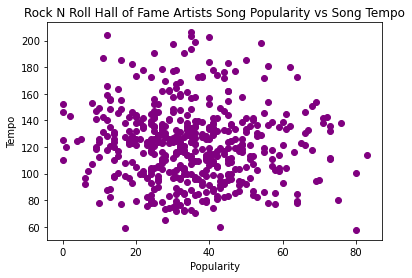

In [19]:
# Scatterplot of song popularity vs song tempo for RnR HoF'ers

x = sample(list(rnrhofdata_df.popularity),500)
y = sample(list(rnrhofdata_df.tempo),500)
plt.scatter(x,y, c='purple')
plt.title("Rock N Roll Hall of Fame Artists Song Popularity vs Song Tempo")
plt.xlabel("Popularity")
plt.ylabel("Tempo")
plt.show()

In [20]:
grouped_rnrhofdata = rnrhofdata_df[['explicit', 'popularity']] #splitting out just the explicit column and popularity column
grouped_rnrhofdata2 = grouped_rnrhofdata.groupby('explicit').mean() #grouping by explicitness and finding the average score

In [21]:
grouped_rnrhofdata2

,popularity
explicit,
0,34.094344
1,43.452107


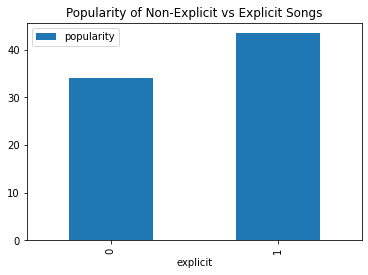

In [22]:
# bar chart showing the average popularity of Explicit songs to ~10 bps higher than non-explicit songs
grouped_rnrhofdata2.plot(kind='bar', title='Popularity of Non-Explicit vs Explicit Songs')

In [23]:
# just looking at RnR HoF data from the wiki page

inductedby_rnrhofdata = rnrhof['Inducted By'] #subsetting only the inductors for each artist
inductedby_rnrhofdata.dropna() #dropping na rows...not sure why this didn't take out the nan field below
i = Counter(inductedby_rnrhofdata) #counting the number of times each name appears
most_common = i.most_common(9) #only taking the most common 9 names. Starting with 10 the frequency dropped to 3
induct_dict = dict(most_common) #creating a dictionary from the list

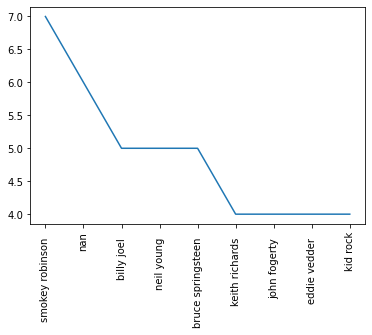

In [24]:
# line chart of the frequency of inductors. Smokey Robinson inducted more RnR HoFers than anyone else by 2. Billy Joel was 2nd
induct_list = induct_dict.items()
x, y = zip(*induct_list)
plt.plot(x,y)
plt.xticks(rotation='vertical')
plt.show()

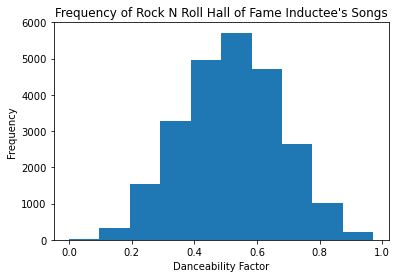

In [25]:
# Frequency distribution of the danceability of songs for RnR HoFers
plt.hist(rnrhofdata_df['danceability'])
plt.title('Frequency of Rock N Roll Hall of Fame Inductee\'s Songs')
plt.xlabel('Danceability Factor')
plt.ylabel('Frequency')
plt.show()